<a href="https://colab.research.google.com/github/pablitocito/Diffusion_model_project/blob/main/src/sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion model

## Essentials



### Packages

In [27]:
#local %pip install -r C:/Users/UTILISATEUR/Desktop/M2/Diffusion_model_project/requirements.txt

#collab
!pip3 install --upgrade pip
!pip3 install einops
!pip3 install --upgrade diffusers[torch]
!pip3 install diffusers[training]==0.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached diffusers-0.11.1-py3-none-any.whl (524 kB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.5.1
    Uninstalling diffusers-0.5.1:
      Successfully uninstalled diffusers-0.5.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached diffusers-0.5.1-py3-none-any.whl (236 kB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.11.1
    Uninstalling diffusers-0.11.1:
      Successfully uninstalled diffusers-0.11.1


In [28]:
#Gif
import imageio
import einops
import os

#Usefull
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from PIL import Image

#Torch and hugging face diffuseur
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision import transforms
from torchvision.datasets.mnist import MNIST, FashionMNIST
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator, notebook_launcher
import torch.nn.functional as F


#Config
from dataclasses import dataclass

torch.cuda.empty_cache()

In [29]:
# Setting reproducibility
SEED = 63
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [30]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


### Execution option


In [31]:
store_path = "ddpm_fashion.pt"

In [32]:
@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size =128
    eval_batch_size = 128# how many images to sample during evaluation
    num_epochs = 20
    gradient_accumulation_steps = 1
    learning_rate = 0.001
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = store_path  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = SEED

config = TrainingConfig()

### Utility functions

In [33]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [34]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

### Load Dataset

**Note** : It is important to normalize images in range [-1,1] and not [0,1] as one might usually do. DDPM network predicts normally distributed noises throughout the denoising process.

In [35]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

ds_fn = FashionMNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=preprocess)
loader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

<ipython-input-33-41ca7b27e20f>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(rows, cols, idx + 1)


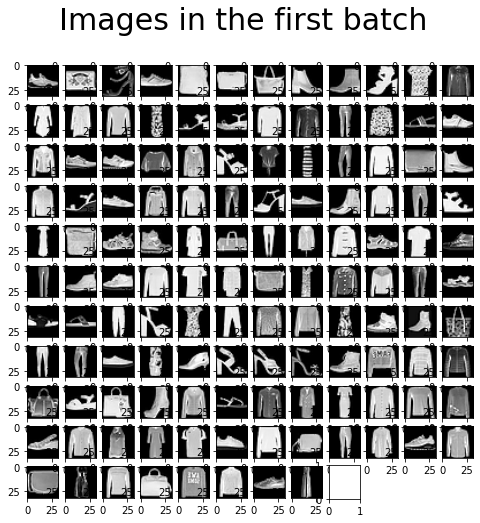

In [36]:
# Optionally, show a batch of regular images
show_first_batch(loader)

## The diffusion model

### U-net

In [37]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 32, 64, 64, 128, 128),  # the number of output channels for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

Check wherEas the ouput and input of the U-Net are the same

In [38]:
sample_image = dataset[0][0].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 1, 32, 32])


In [39]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 32, 32])


### Noise scheduler

In [40]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

### Prepare training


  We use an AdamW optimiesr

In [41]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

Add cosine learning rate schedule:

In [42]:
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(loader) * config.num_epochs),
)

### Training function


In [43]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler,display=False):
    best_loss = float("inf")
    
    # Initialize accelerator
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
    )
    if accelerator.is_main_process:
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch + 1}/{config.num_epochs}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1



        


        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if best_loss > loss.detach().item():
                best_loss = loss.detach().item()
                pipeline.save_pretrained(config.output_dir) 
                print(f'best saved epoch number {epoch}')

In [44]:
args = (config, model, noise_scheduler, optimizer, loader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [51]:
#np.squeeze(np_img, axis=2)
#batch_size = config.eval_batch_size, generator=torch.manual_seed(config.seed),
ddpm =  DDPMPipeline.from_pretrained(config.output_dir)
ddpm().images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: ignored

In [48]:
outputs.images

NameError: ignored

# Need understanding

### Visualizing forward and backward

In [ ]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [ ]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [ ]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [ ]:
samples = sample(ddpm, image_size=config.image_size, batch_size=64, channels=1)

In [ ]:
import matplotlib.animation as animation

random_index = SEED

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(config.image_size, config.image_size, 1), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()